In [1]:
import numpy as np 
import pandas as pd
import re

In [2]:
reviews = pd.read_csv('amazon_baby.csv')

In [3]:
reviews = reviews.dropna()
reviews['review'] = reviews['review'].str.lower()
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [4]:
reviews.head()

,name,review,rating
0,Planetwise Flannel Wipes,these flannel wipes are ok but in my opinion n...,3
1,Planetwise Wipe Pouch,it came early and was not disappointed i love ...,5
2,Annas Dream Full Quilt with 2 Shams,very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,this is a product well worth the purchase i h...,5
4,Stop Pacifier Sucking without tears with Thumb...,all of my kids have cried nonstop when i tried...,5


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

text_data = reviews['review'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)

2023-05-21 15:52:48.115969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 15:52:48.944254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
reviews['review'].tolist()[1]

'it came early and was not disappointed i love planet wise bags and now my wipe holder it keps my osocozy wipes moist and does not leak highly recommend it'

In [ ]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
sequences = tokenizer.texts_to_sequences(text_data)

In [ ]:
max(len(seq) for seq in sequences)

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_seq_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)


In [9]:
from sklearn.model_selection import train_test_split

X = padded_sequences
y = reviews['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [12]:
from tensorflow.keras.models import load_model

model = load_model('amazon_review.h5')

2023-05-21 15:48:37.657457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-21 15:48:37.694499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-21 15:48:37.694732: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[152868,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [11]:
predictions = model.predict(X_test[:1])

2023-05-21 15:07:46.551554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 15:07:46.554138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 15:07:46.555639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 3s 3s/step


In [11]:
predictions

NameError: name 'predictions' is not defined

In [12]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test[:1], predictions)

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.04546689987182617


In [19]:
embedding_weights = model.layers[0].get_weights()[0]
word_index = tokenizer.word_index
index_to_word = {index: word for word, index in word_index.items()}



In [20]:
word_importance = {}
for index, word in index_to_word.items():
    embedding_weight = embedding_weights[index]
    avg_embedding_weight = np.mean(embedding_weight)
    word_importance[word] = avg_embedding_weight

In [21]:
important_words = sorted(word_importance, key=word_importance.get, reverse=True)

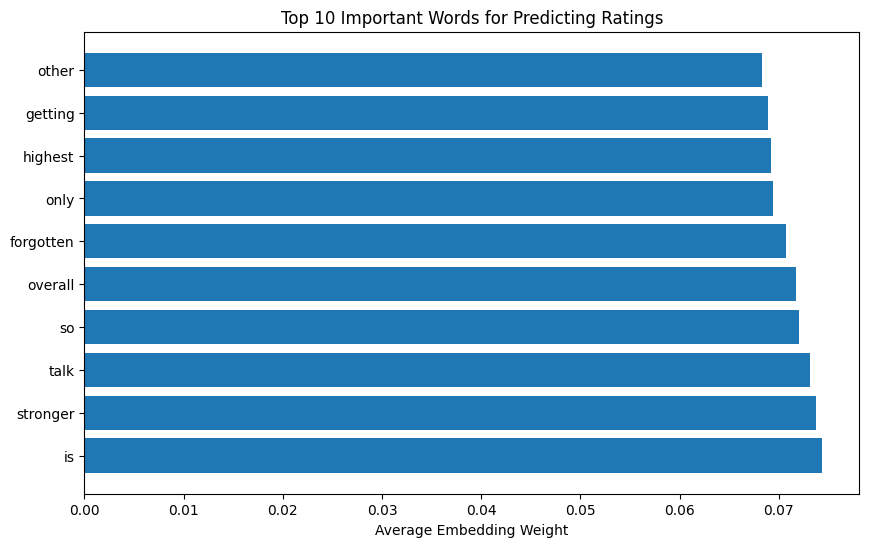

In [22]:
import matplotlib.pyplot as plt

top_n = 10

top_words = important_words[:top_n]
importance_values = [word_importance[word] for word in top_words]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importance_values, align='center')
plt.yticks(range(top_n), top_words)
plt.xlabel('Average Embedding Weight')
plt.title('Top {} Important Words for Predicting Ratings'.format(top_n))
plt.show()